In [2]:
import cv2
import numpy as np
import imutils
import os
import shutil
from matplotlib import pyplot as plt
from IPython.display import Image 
from PIL import Image        
from types import SimpleNamespace
import random as rng
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import pprint
import itertools as it

rng.seed(12345)
pp = pprint.PrettyPrinter(indent=4)

In [3]:
file_ready_for_lines_detection = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/b2432346-2637-5e69-a752-128f71c1bb44-1d8625b3_pg-0_sg-0.jpg")
input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/b2432346-2637-5e69-a752-128f71c1bb44-e2455027_pg-1_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")

In [20]:
# img = cv2.imread(file_ready_for_lines_detection)
img = cv2.imread(input_file)
orig_img = cv2.imread(input_file)
line_only_img = cv2.imread(file_ready_for_lines_detection)

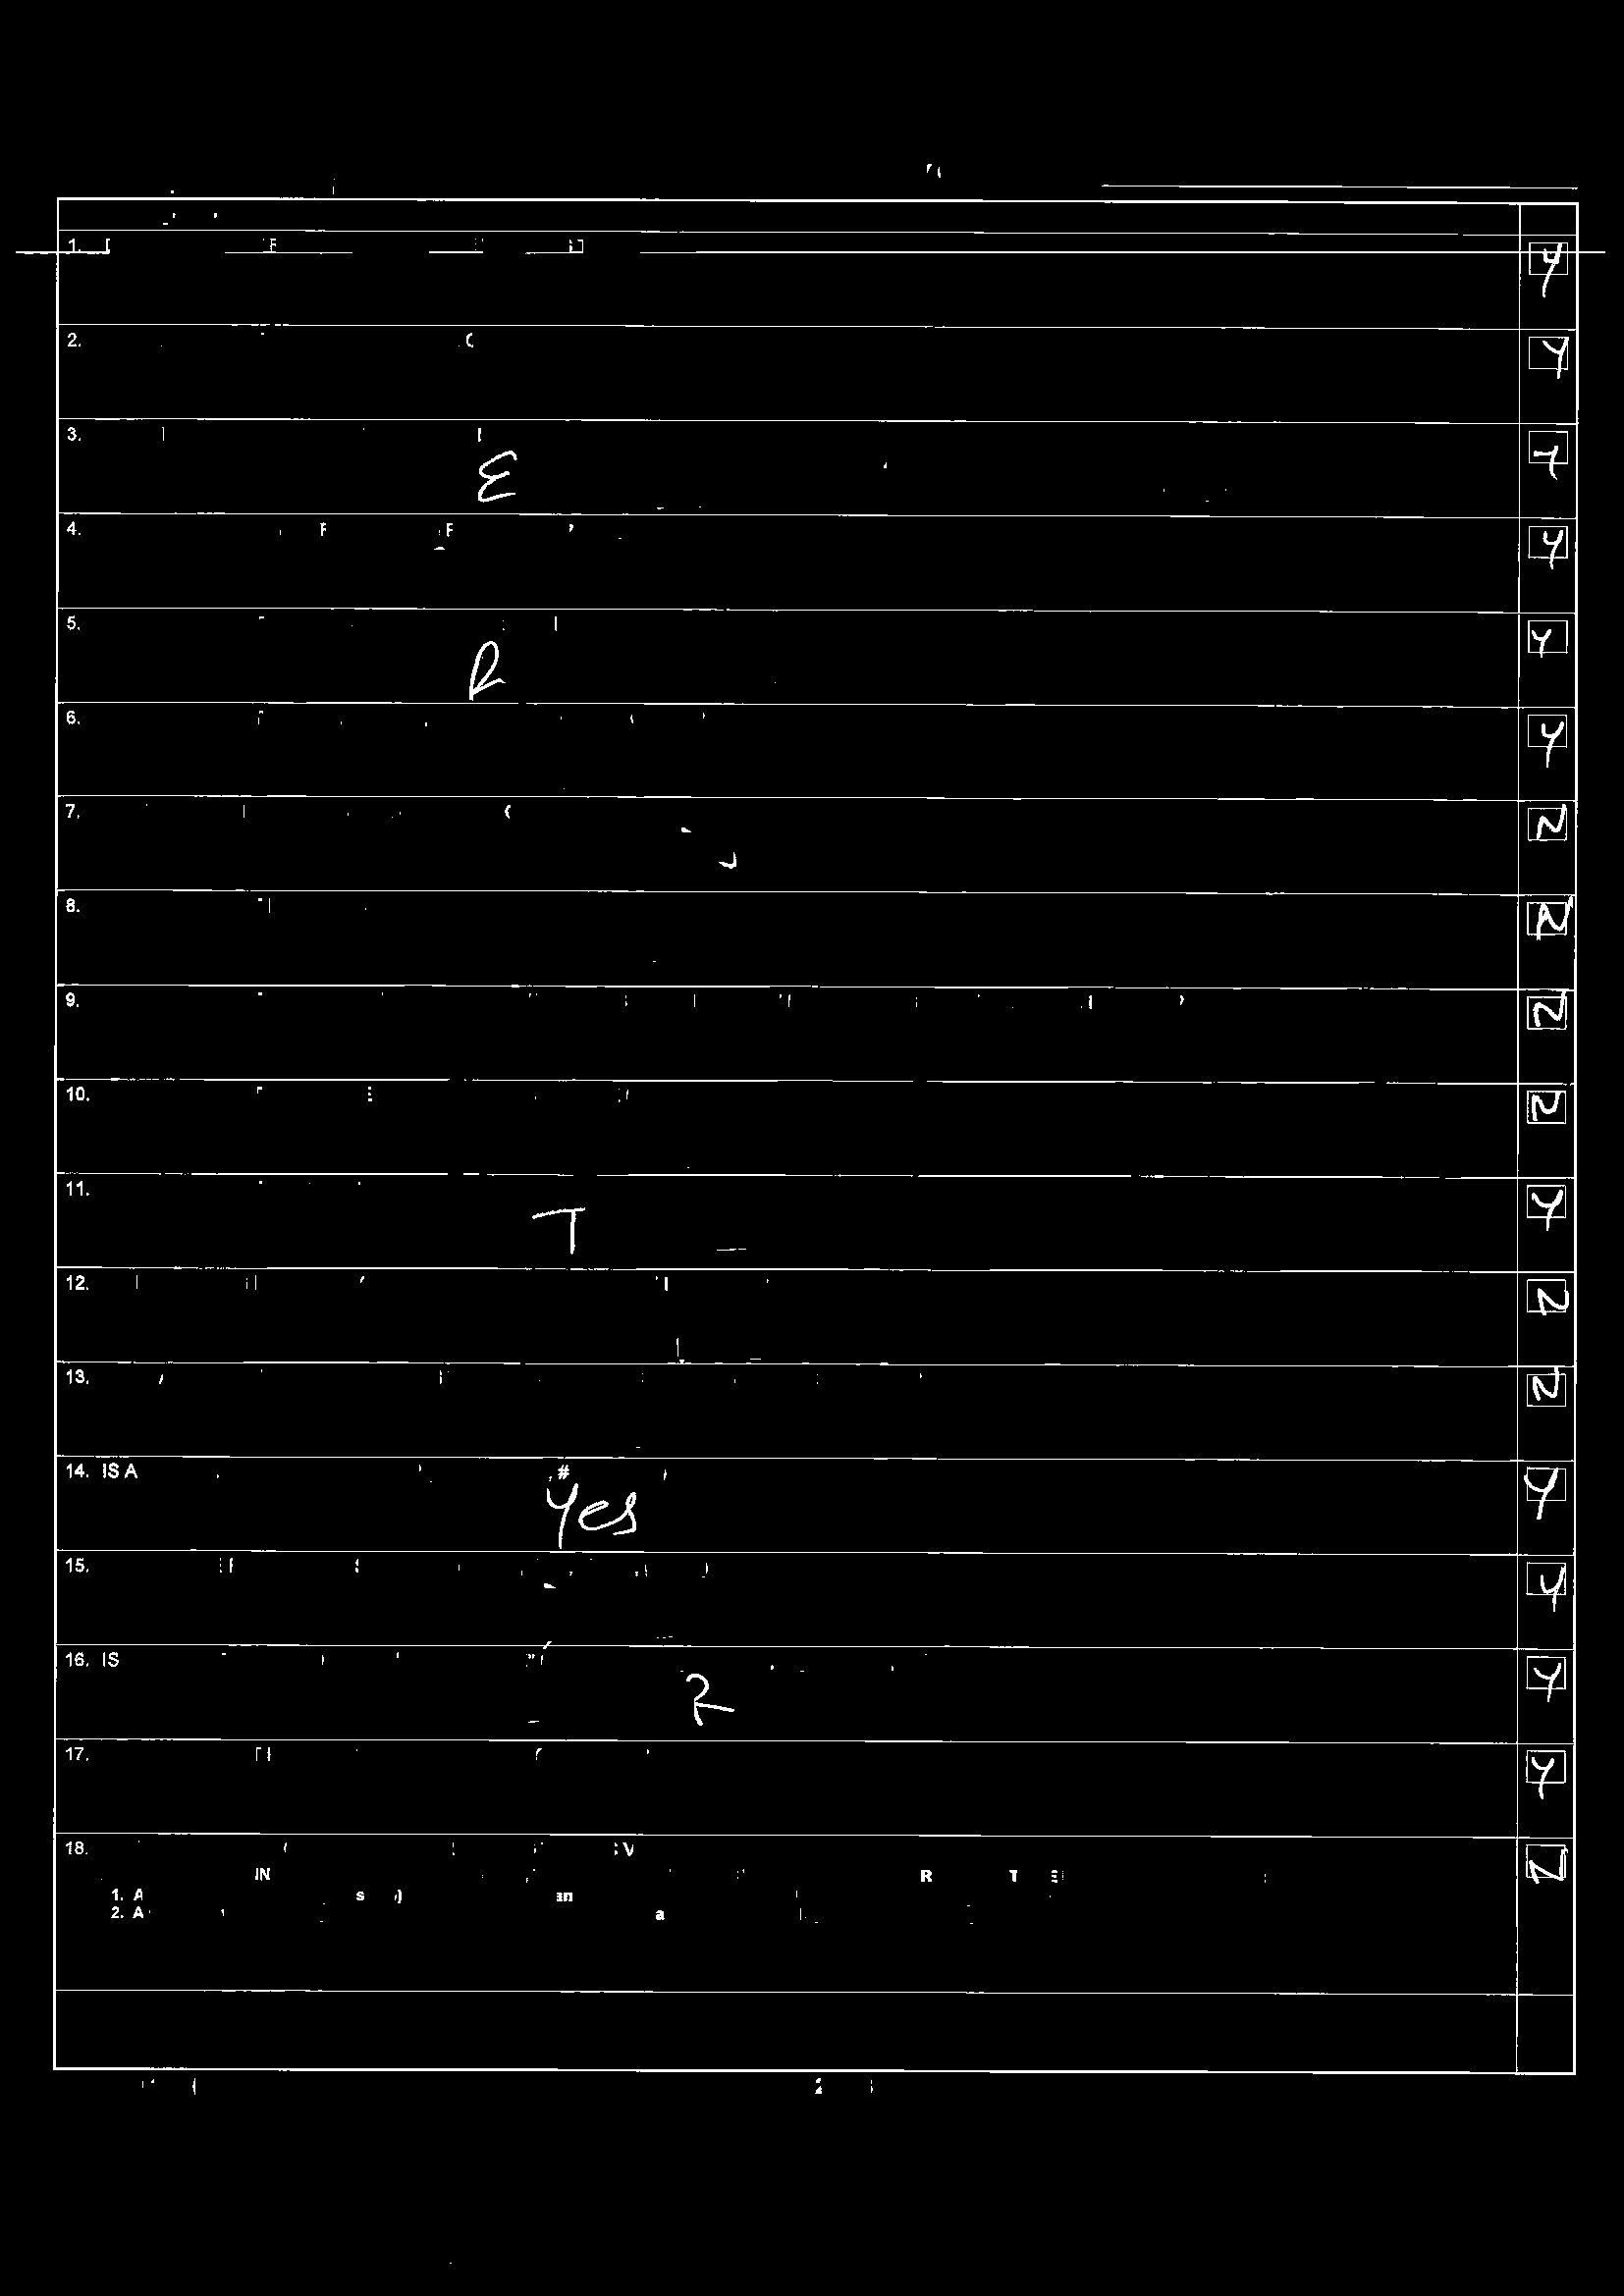

In [21]:
img_out_g_i_t = get_image_threshold_bin(img)
display(Image.fromarray(img_out_g_i_t))

In [ ]:
eroded_and_dilated = image_dilate_erode_transform(img_out_g_i_t)
display(Image.fromarray(eroded_and_dilated))

Total points original = 4431
Total points after = 1409
Total removed = 3022


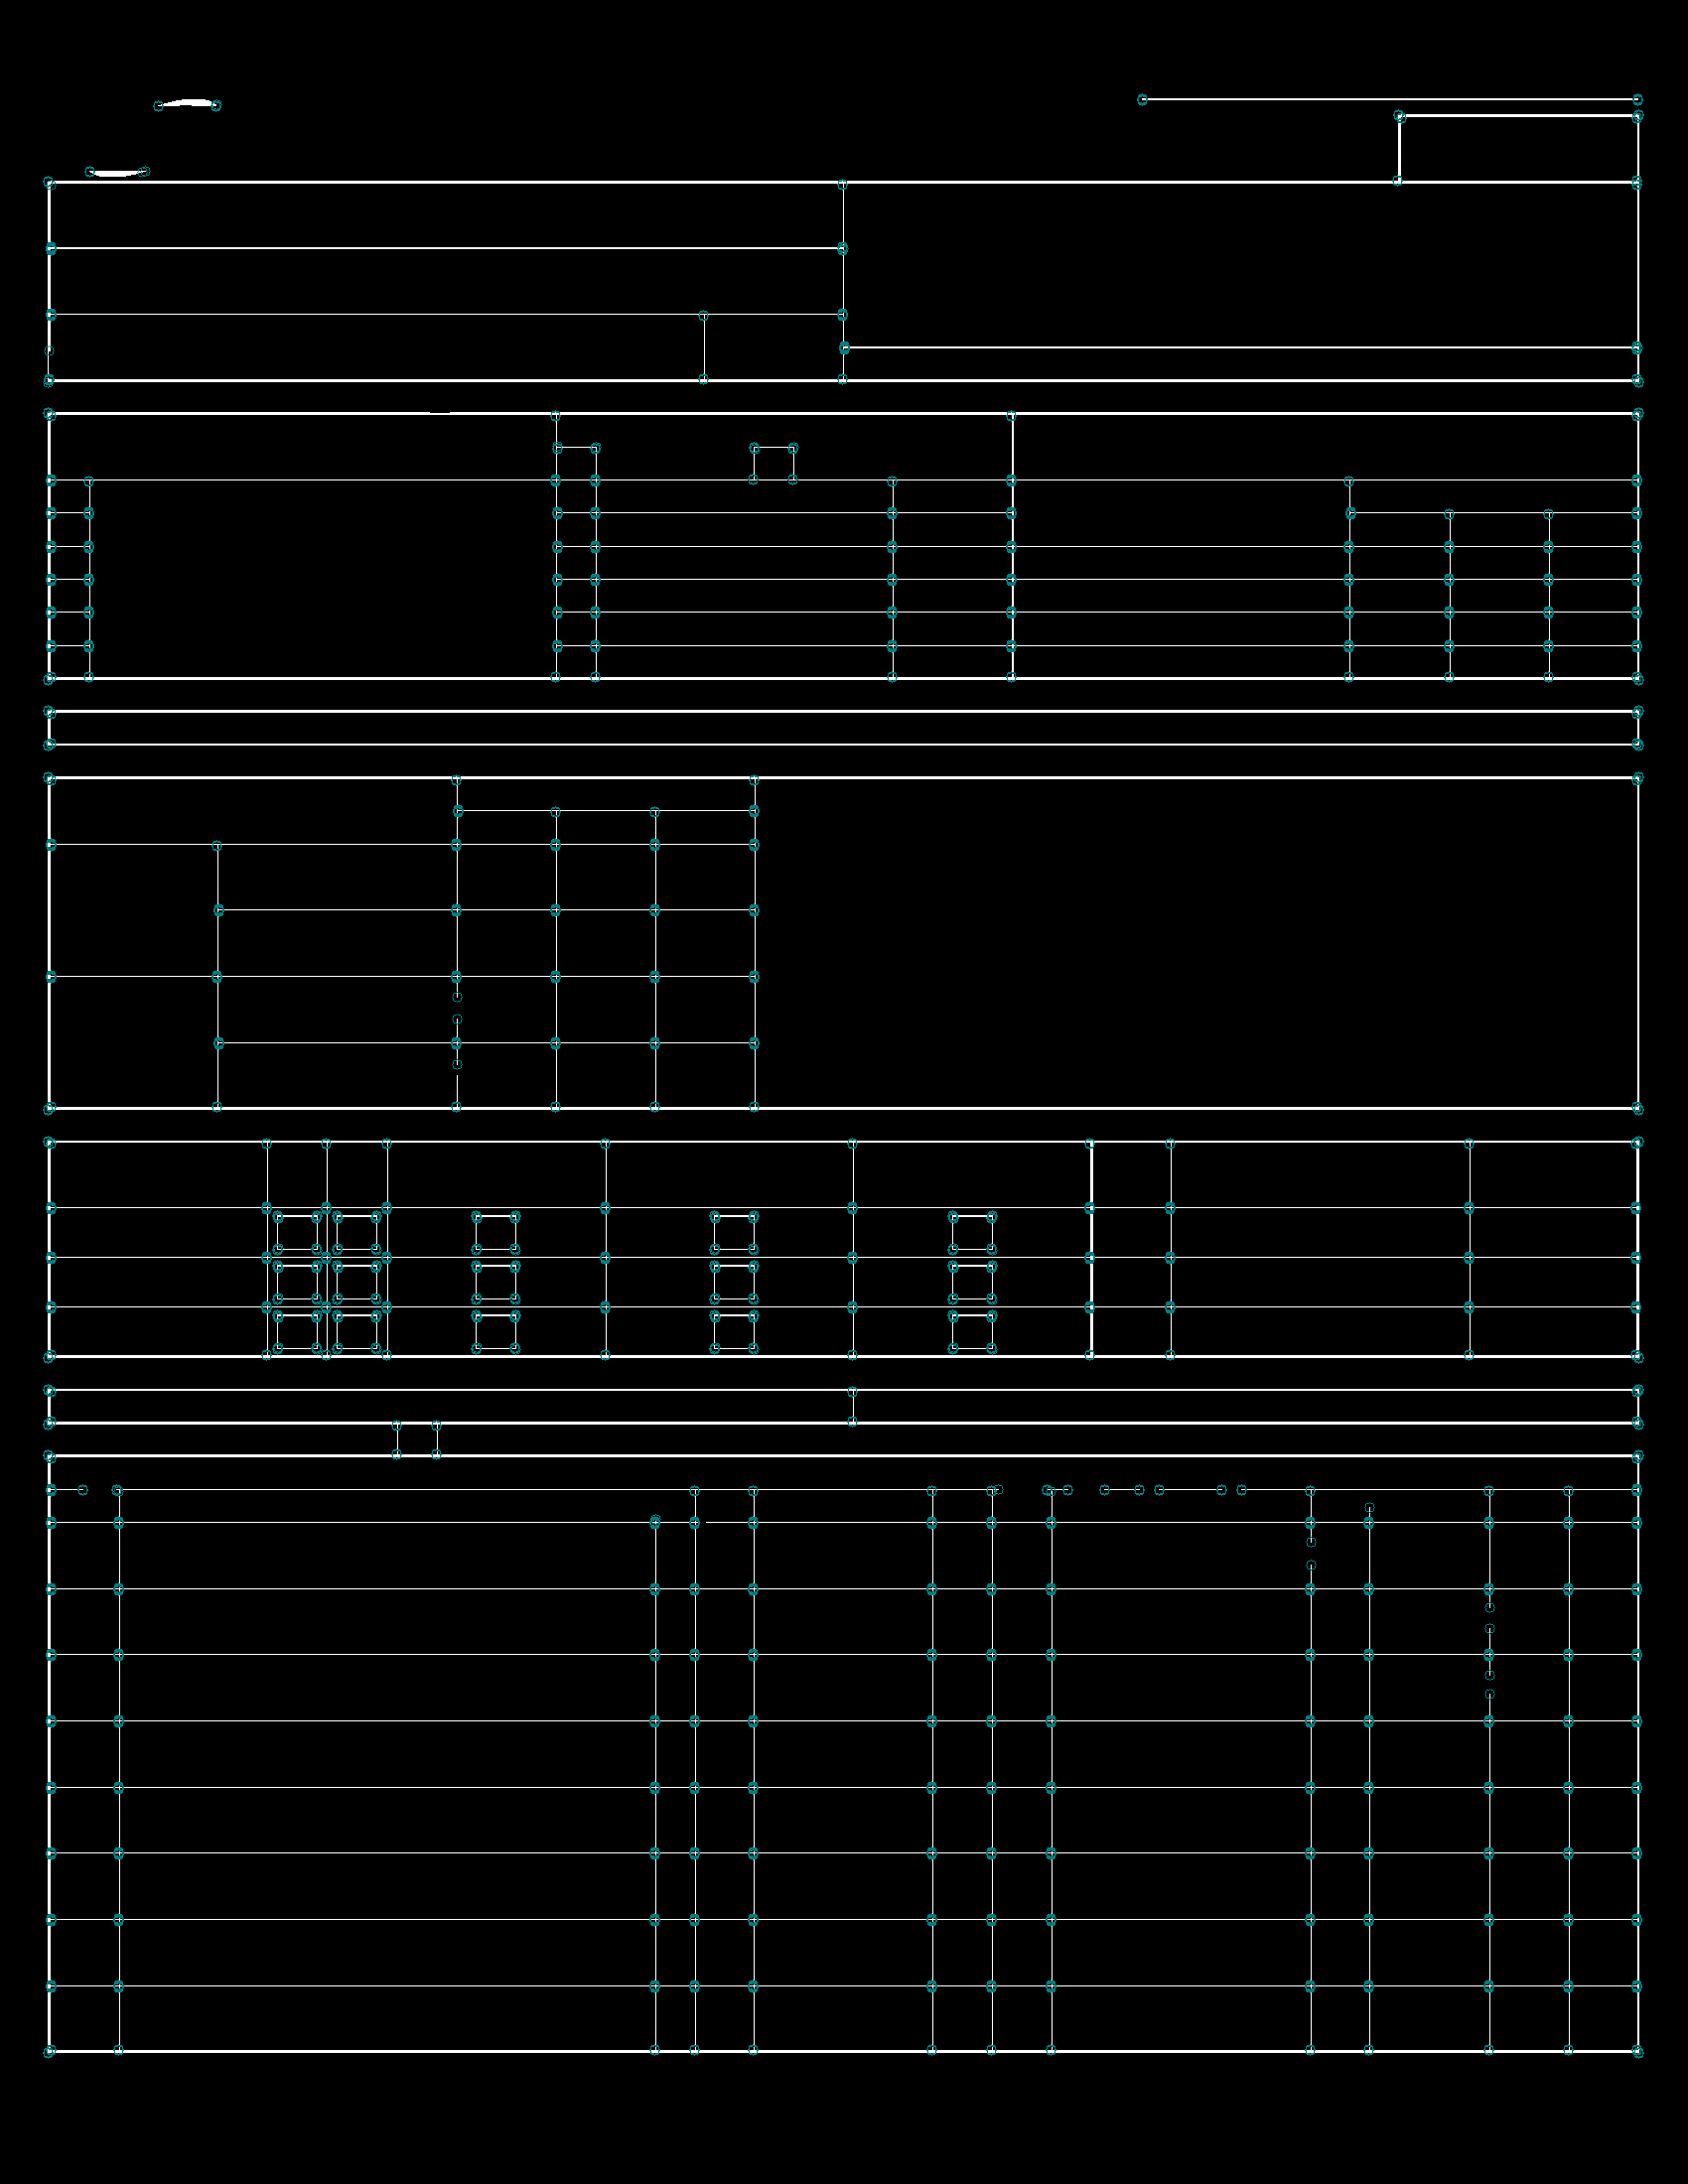

In [66]:
corner_points_img = plot_points_on_img(eroded_and_dilated)
display(Image.fromarray(corner_points_img))

Total points original = 4431
Total points after = 1409
Total removed = 3022


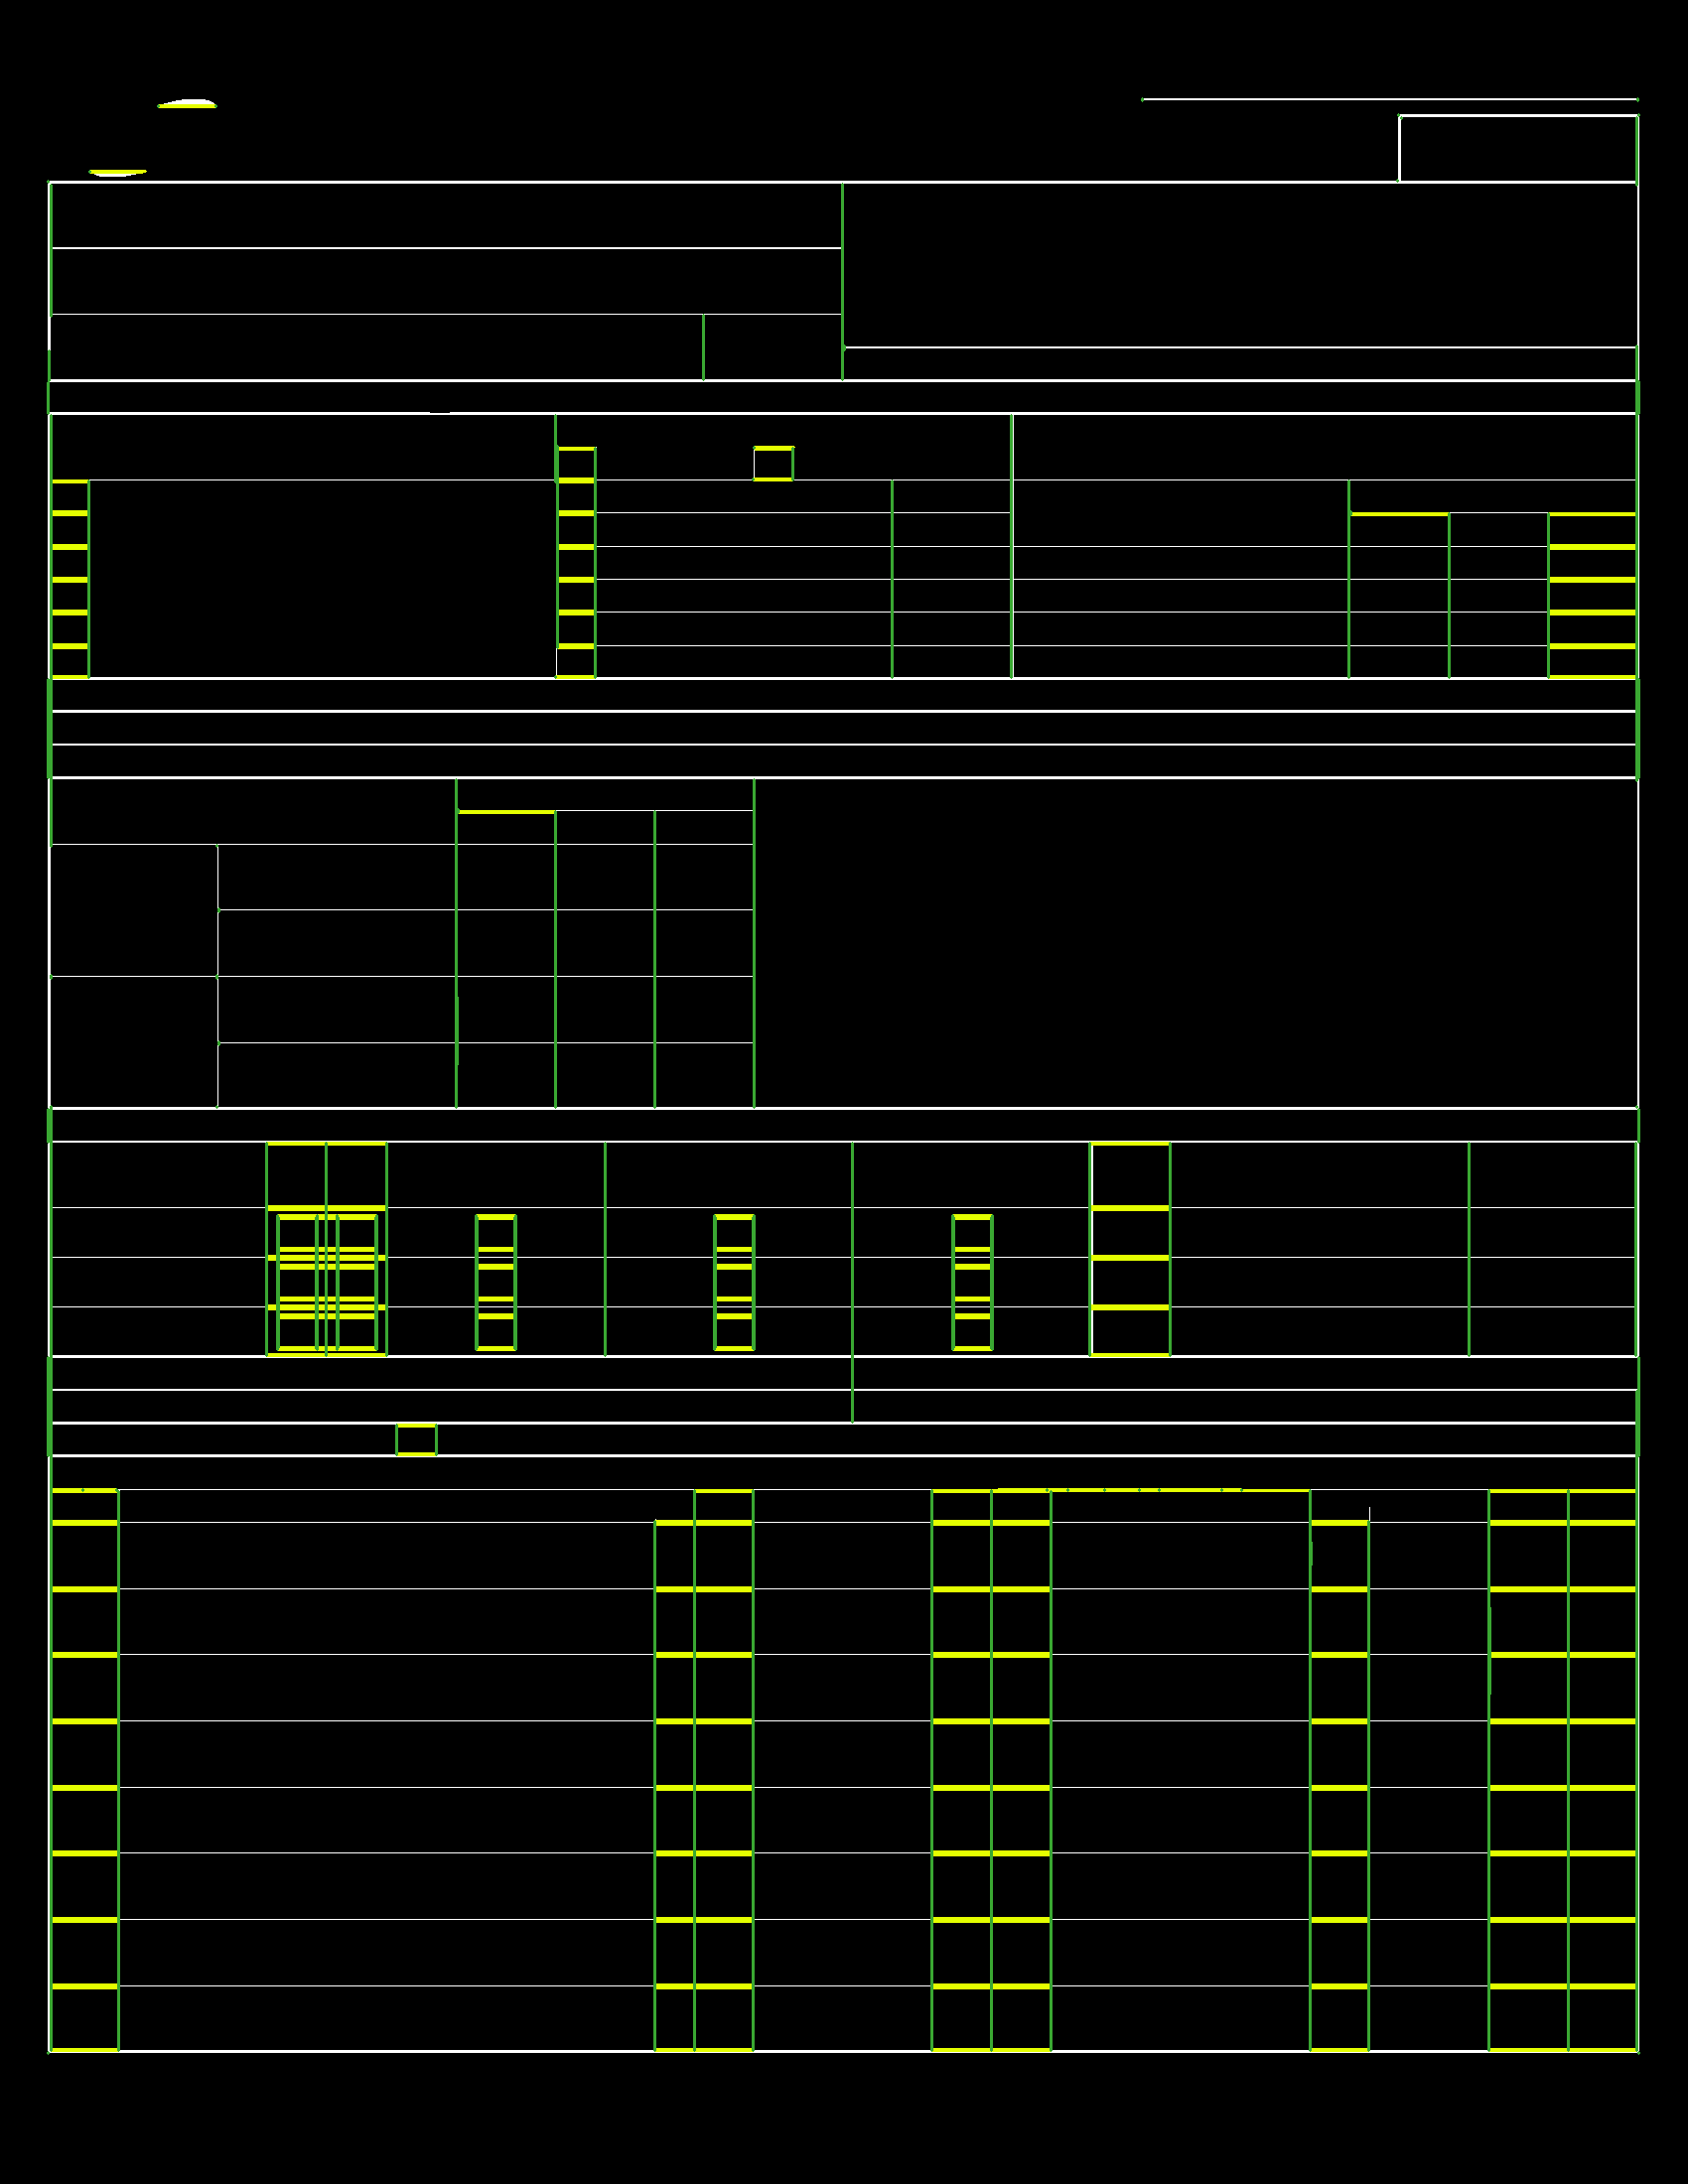

In [67]:
img_out_gap_filled = draw_lines_between_nearest_axis_points(eroded_and_dilated)
display(Image.fromarray(img_out_gap_filled))

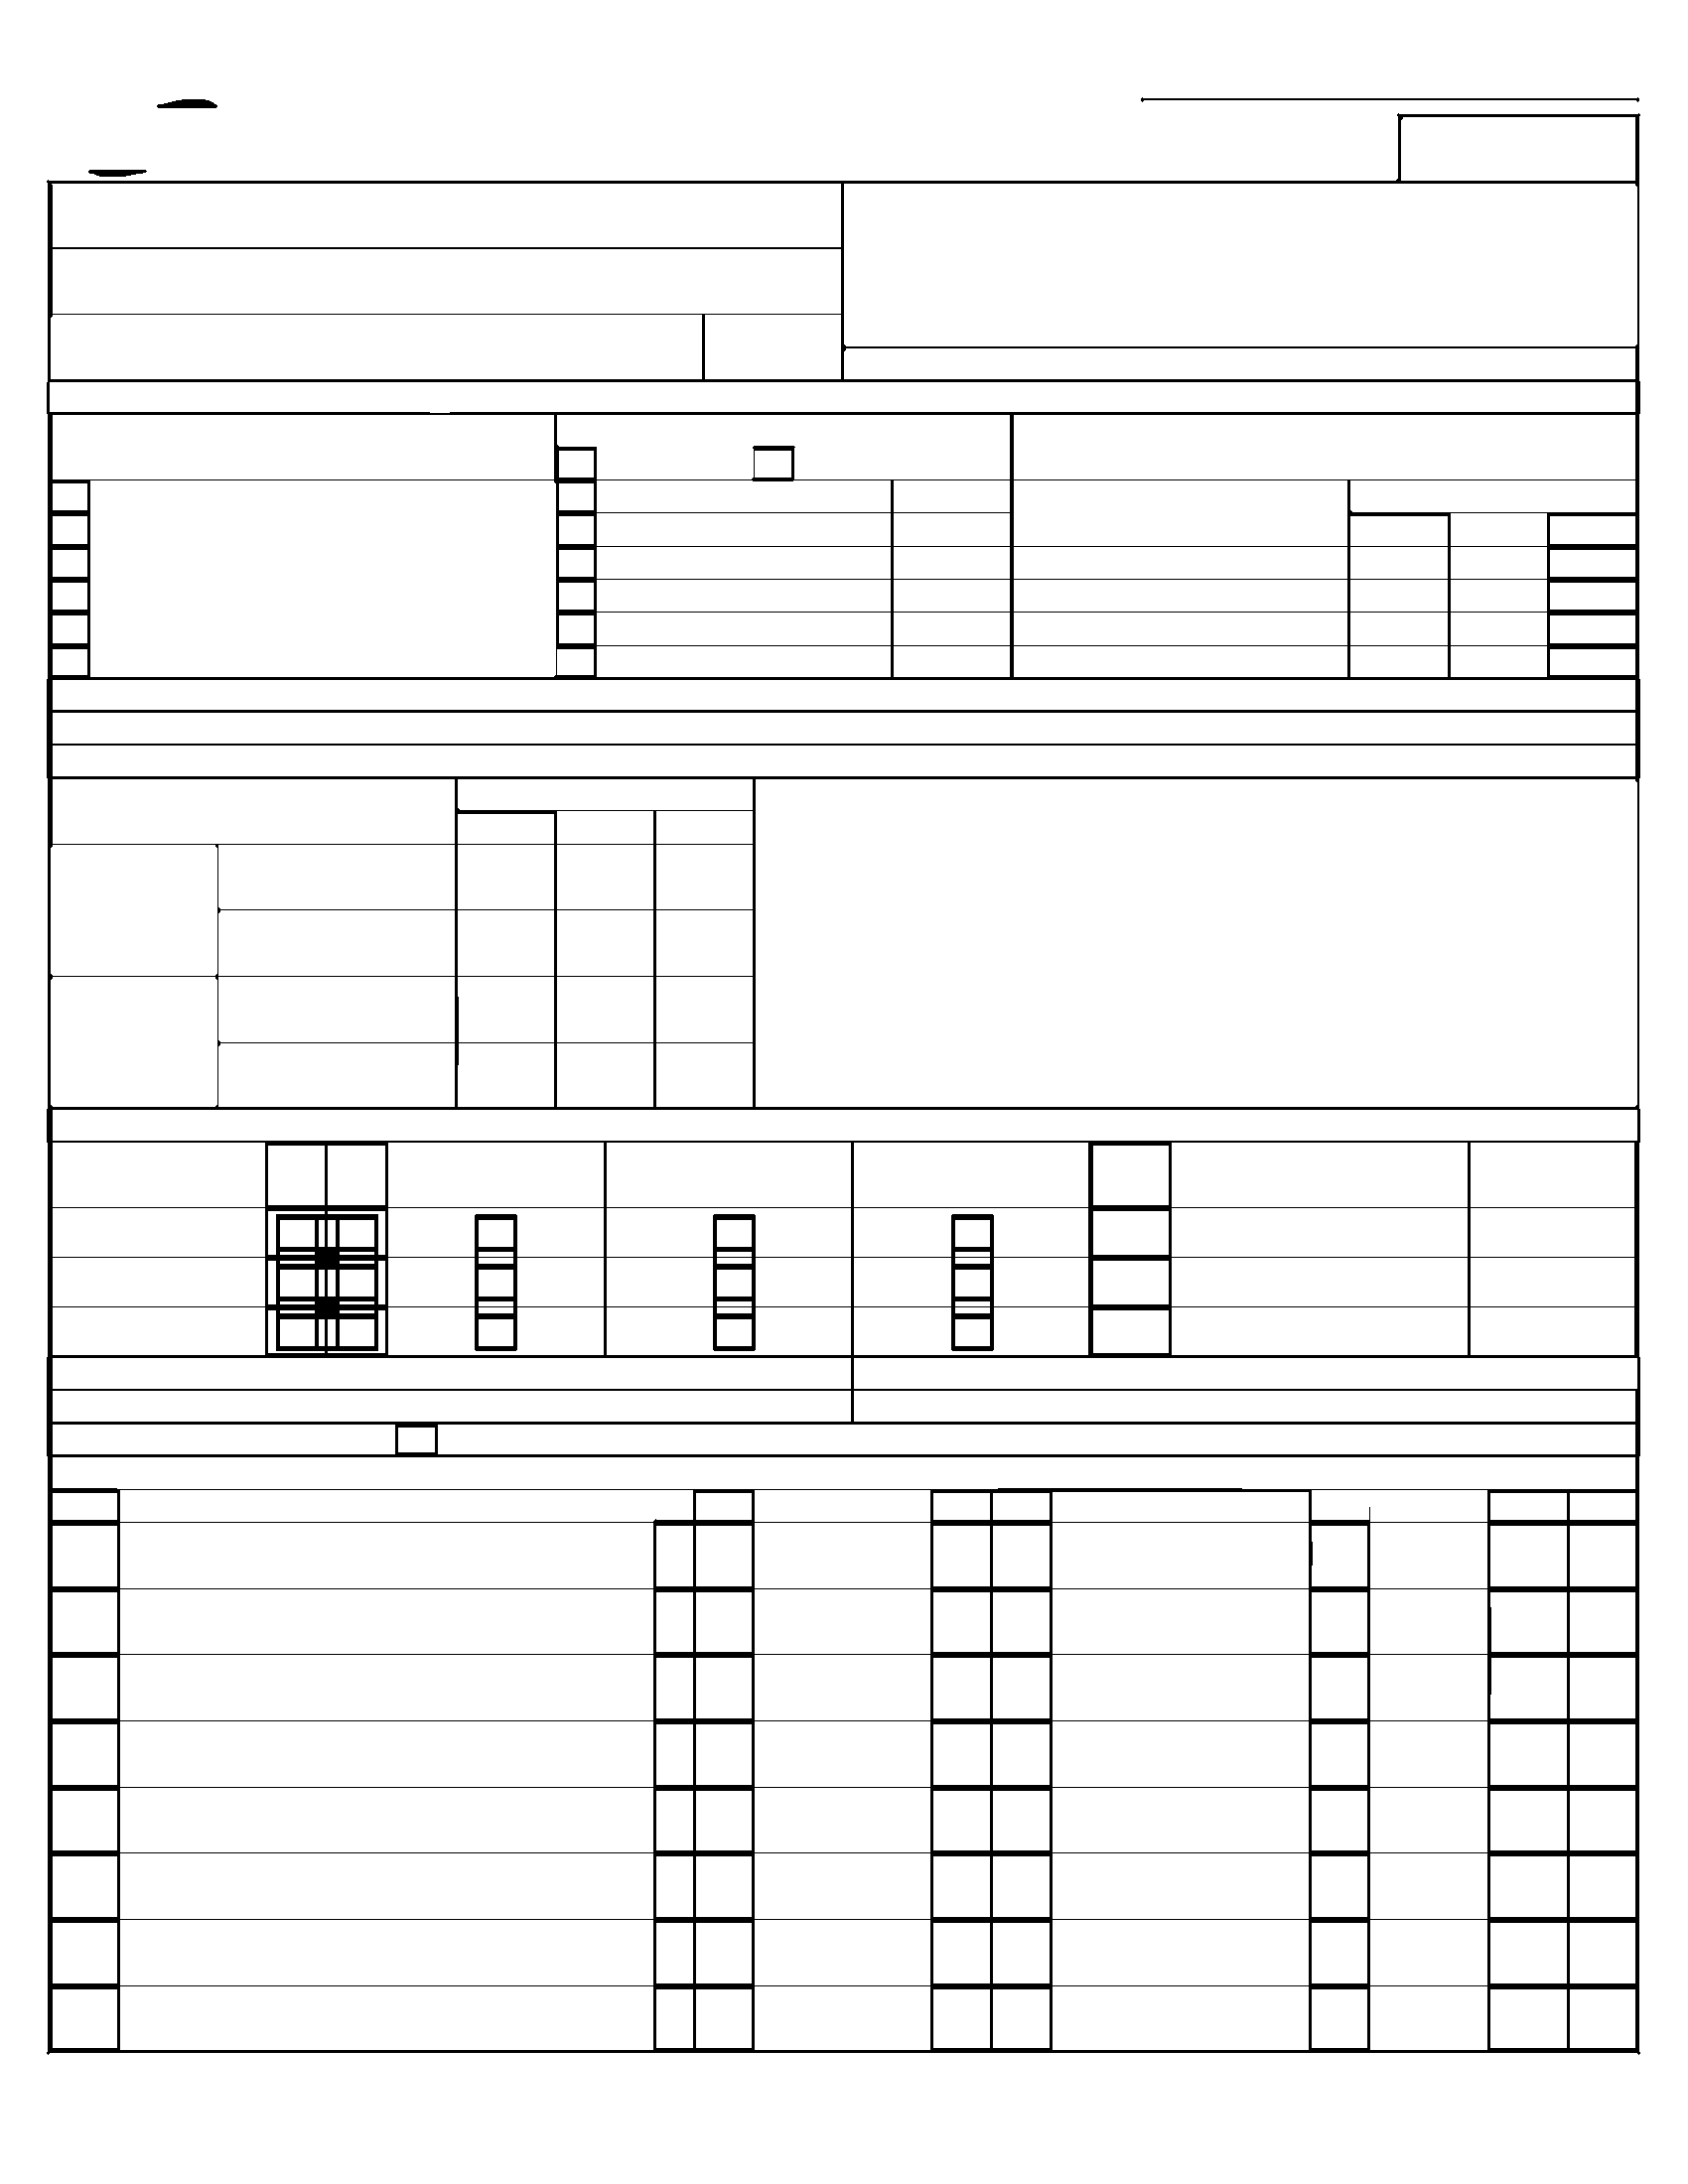

In [68]:
eroded_and_dilated2 = image_dilate_erode_transform(get_image_threshold_bin(img_out_gap_filled))
display(Image.fromarray(eroded_and_dilated2))

detected rectangles = 285


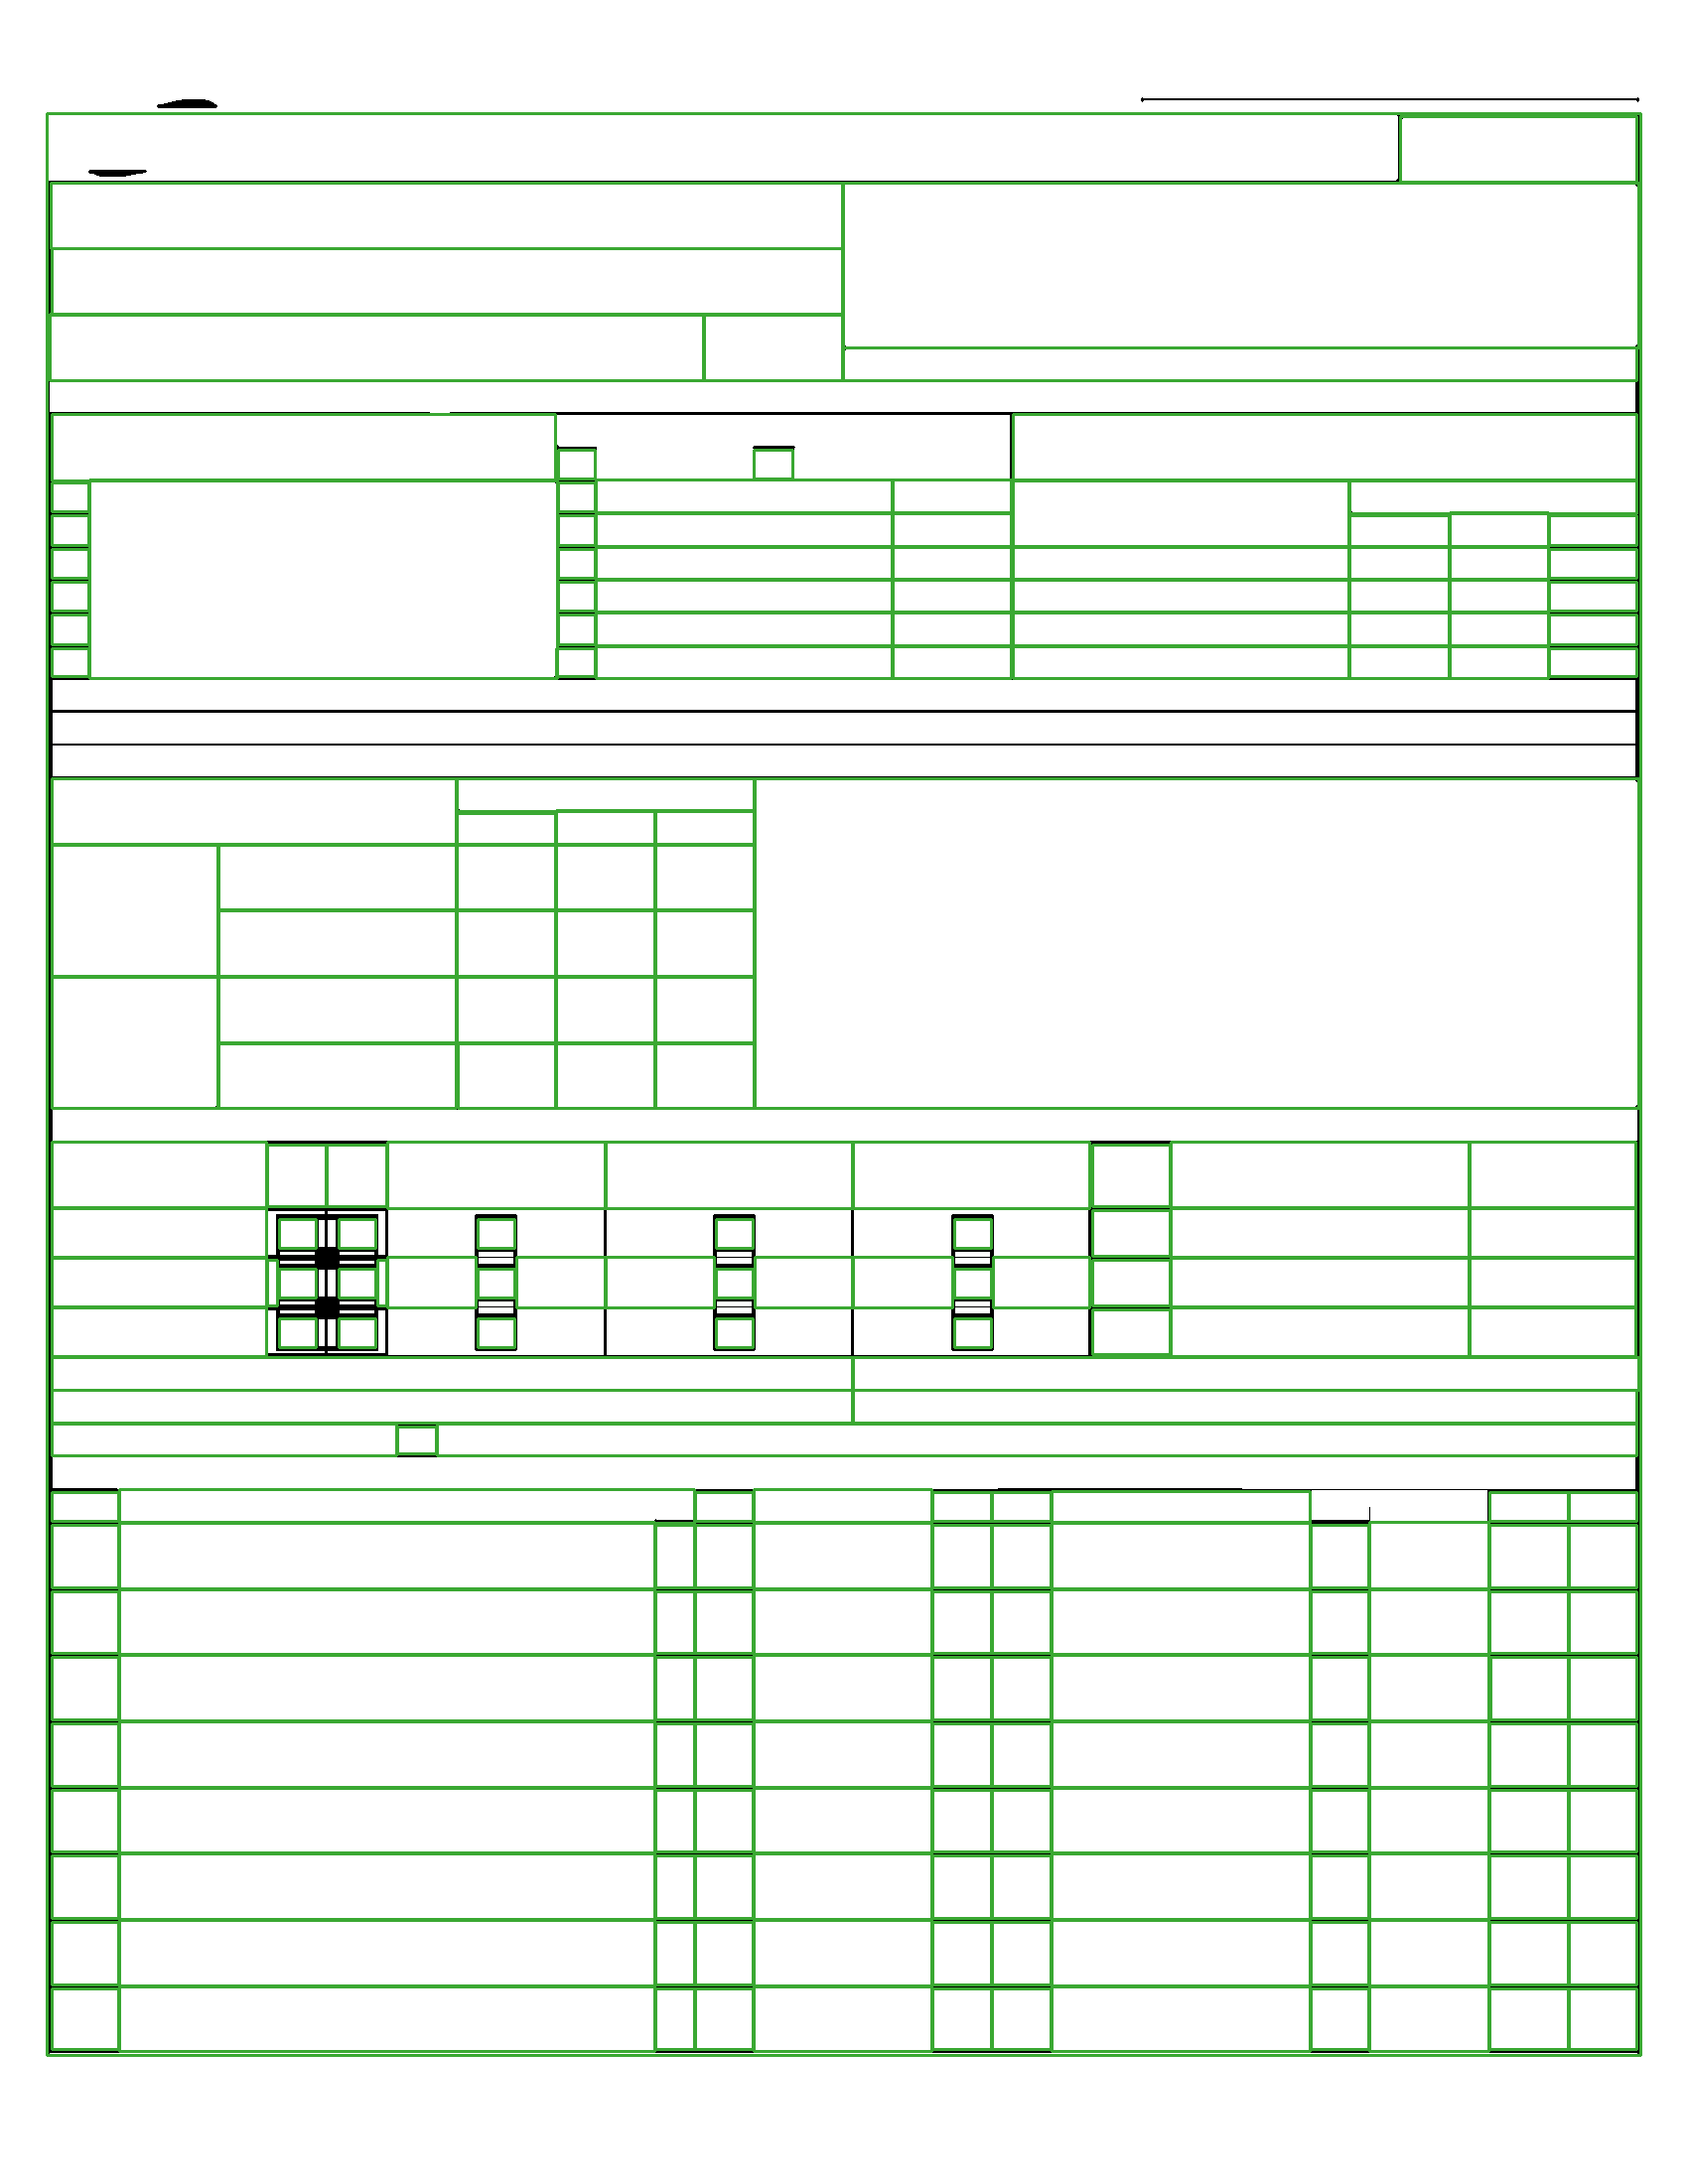

In [69]:
rect_img = draw_rectangles_on_image(eroded_and_dilated2)
display(Image.fromarray(rect_img))

## functions

In [5]:
def get_color(src):
    # [gray]
    # Transform source image to gray if it is not already
    if len(src.shape) == 2:
        color = cv2.cvtColor(src,cv2.COLOR_GRAY2RGB)
    else:
        color = src.copy()
    
    return color

In [6]:
def get_gray(src):
    # [gray]
    # Transform source image to gray if it is not already
    if len(src.shape) != 2:
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else:
        gray = src.copy()
    
    return gray

In [7]:
def get_image_threshold_bin(img):
    
    gray = get_gray(img)
    (thresh, img_gray) = cv2.threshold(gray, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255-img_gray
    
    return img_bin
    

In [8]:
import math

def distance_between_points(pt1, pt2):
    if (len(pt1) > 2):
        (x1, y1, z), (x2, y2, z) = pt1, pt2
    else:
        (x1, y1), (x2, y2) = pt1, pt2    
    dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

In [9]:

def get_line_intersection_points(img):
    
#     gray = get_gray(img)
#     gray = np.float32(gray)
#     dst = cv2.cornerHarris(gray,5,3,0.04)
#     ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
#     dst = np.uint8(dst)
#     ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
#     corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
        
    gray_img = get_gray(img)        
    dst = cv2.cornerHarris(gray_img,2,3,0.04)      
    mask = np.zeros_like(img)
    mask[dst>0.05*dst.max()]=[0,0,255]
    coordinates = np.argwhere(mask)
    
    coor_list = [list(map(int,l.tolist())) for l in list(coordinates)]
    coor_tuples = [tuple(l) for l in coor_list]
    
    thresh = 15
    
    save_tuples = coor_tuples.copy()
    coor_tuples_copy = coor_tuples

    i = 1
    for pt1 in coor_tuples:

#         print(' I :', i)
        for pt2  in coor_tuples[i::1]:        
            dist = distance_between_points(pt1, pt2)
#             print(pt1, pt2, dist)
            if (dist > thresh):
                break;

#             print('cnt = ' +str(i)+ ', Distance :', dist)
            if(dist < thresh):
                coor_tuples_copy.remove(pt2)      

        i+=1
    
    print("Total points original = "+str(len(save_tuples)))
    print("Total points after = "+str(len(coor_tuples_copy)))
    print("Total removed = "+str(len(save_tuples) - len(coor_tuples_copy)))

    
    return coor_tuples


In [10]:
def plot_points_on_img(img, coordinate_tuples=None):
    
    plt_img = get_color(img)
    if (coordinate_tuples == None):
        coordinate_tuples = get_line_intersection_points(plt_img)
        
    for point in [tuple([x,y]) for y,x,_ in coordinate_tuples]:
#         pp.pprint(point)
        cv2.circle(plt_img, point,5, (0,128,128), 0)
    
    return plt_img
    

In [11]:
def draw_lines_between_nearest_axis_points(img):

    plt_img = get_color(img)
    
    coordinate_tuples = get_line_intersection_points(plt_img) 
    x_tuples = [tuple([x,y]) for y,x,_ in coordinate_tuples]
    y_tuples = [tuple([y,x]) for y,x,_ in coordinate_tuples]

    x_dict = {k:tuple(x[1] for x in v) for k,v in it.groupby(sorted(x_tuples), key=lambda x: x[0])}
    y_dict = {k:tuple(x[1] for x in v) for k,v in it.groupby(sorted(y_tuples), key=lambda x: x[0])}

    line_drawn = []
    only_point_img = get_color(img)
    y_dict_copy = y_dict
    gap_thres = 100
    for key in y_dict:        
        x_vals = x_vals_cpy =  y_dict[key]
        i = 0
        for x1 in x_vals:        
            i +=1
            for x2 in x_vals_cpy[i::1]:
                pt1 = (x1,key,0)
                pt2 = (x2,key,0)            
                dist = distance_between_points(pt1, pt2)
                if dist < gap_thres and ((pt1,pt2) not in line_drawn):
                    line_drawn.append((pt1,pt2))
                    cv2.line(only_point_img,(pt1[0],pt1[1]),(pt2[0],pt2[1]), (228, 255, 0), thickness=2, lineType=8)

    line_drawn = []
    for key in x_dict:        
        y_vals = y_vals_cpy =  x_dict[key]
        i = 0
        for y1 in y_vals:        
            i +=1
            for y2 in y_vals_cpy[i::1]:
                pt1 = (key,y1,0)
                pt2 = (key,y2,0)
                dist = distance_between_points(pt1, pt2)
                if dist < gap_thres and ((pt1,pt2) not in line_drawn):
                    line_drawn.append((pt1,pt2))
                    cv2.line(only_point_img,(pt1[0],pt1[1]),(pt2[0],pt2[1]), (58, 168, 50), thickness=2, lineType=8)
    
    return only_point_img



In [12]:
def get_rectangles_in_image(img, strict=True):
    
    id= -1
    MIN_BOUNDED_AREA = 5
    thresh_img = get_image_threshold_bin(img)
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    boundRect = [None]*len(contours)
    overlay_img = get_color(img)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)    
        color = ((245+id*2 % 255), 90, 66)
        if (len(approx)==4 or (not strict)) and (cv2.contourArea(cnt) > MIN_BOUNDED_AREA):
            id += 1
            boundRect[id] = cv2.boundingRect(approx)
    
    print("detected rectangles = "+str(len(boundRect)))
    return boundRect
            
    

In [13]:
def draw_rectangles_on_image(img):
    
    overlay_img = get_color(img)
    rectangles = get_rectangles_in_image(overlay_img)
    color = (58, 168, 50)
    for rect in rectangles:
#         pp.pprint(rect)
        if (rect != None):
            cv2.rectangle(overlay_img, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), color, 2) 
   
    return overlay_img


In [14]:
def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
    
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
    
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
    
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
            key=lambda b:b[1][i], reverse=reverse))
    
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)

In [15]:
def sort_poly(p):
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]

In [16]:
def canny_blur(img):        
    blurred = cv2.GaussianBlur(img, (3, 3), 10)
    canny = auto_canny(blurred)
    return canny

In [17]:
def image_dilate_erode_transform(img_bin):

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))

    horizontal_lines_img = cv2.erode(img_bin, hori_kernel, iterations=10)
    horizontal_lines_img = cv2.dilate(horizontal_lines_img, hori_kernel, iterations=10)
    # morpho close vertical
    vertical_lines_img = cv2.erode(img_bin, verticle_kernel, iterations=10)
    vertical_lines_img = cv2.dilate(vertical_lines_img, verticle_kernel, iterations=10)

    img_final_bin = vertical_lines_img | horizontal_lines_img
    
    return img_final_bin

In [18]:
import matplotlib as mpl

def plt_show(img, cmap='gray'):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap)

    plt.show()

In [19]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged